In [1]:
# モジュールのインポート
from matplotlib import pyplot
from matplotlib import patches
import random
import numpy as np
import array
import math

from itertools import repeat
from collections.abc import Sequence
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

In [2]:
# roomというclassを作る
class Room():
    def __init__(self,n,m,w=0,l=3,x=0,ud=3):
        self.n = n # number
        self.m = m # move_frequency
        self.w = w # width
        self.l = l # length
        self.x = x # exitpoint
        self.ud = ud # up and down
    # aとbとの距離
    def distance(self,b):
        return (abs( self.x - b.x )+ abs( self.ud - b.ud )) * self.m[b.n-1]
    # 壁
    def wall(self):
        return (self.w+self.l)*2
    # 床
    def floor(self):
        if self.w == 1:
            S = self.w*self.l+5*(8-self.l)+28
        elif self.l == 1:
            S = self.w*self.l+5*(8-self.w)+28
        elif self.w == 2 and self.l == 2:
            S = self.w*self.l+5
        else:
            S = (self.w*self.l)
        return S
    # 左の座標
    def leftpoint(self):
        return self.x-self.w/2
    # 右の座標
    def rightpoint(self):
        return self.x+self.w/2
    def display(self):
        print(f"番号:{self.n}　幅:{self.w}　奥行:{self.l}　入口:{self.x}　北南:{self.ud}")

In [154]:
# 遺伝子を生成
def room_gene():
    seq = [random.sample(range(0,9),9)] # 順番
    dim_gap = [random.randint(0,1) for i in range(54)]# 縦と横、北と南の部屋群とのずれ
    gene = seq + dim_gap
    return gene

# 遺伝子を用途ごとに分解し、二進数を十進数に変換
def disassembly(individual):
    seq = individual[0]
    gap = individual[1:7]
    dim = individual[7:]
    deci_gap = 0
    _gap = gap[1:]
    for i, bit in enumerate(reversed(_gap)):
        if bit == 1:
            deci_gap += 2 ** i
    if gap[0] == 0:
        deci_gap = deci_gap * -1
    deci_dim = []
    n = 3
    for i in range(0, len(dim), n):
        decimal_num = 1
        for i, bit in enumerate(reversed(dim[i: i+n])):
            if bit == 1:
                decimal_num += 2 ** i
        deci_dim.append(decimal_num)
    return seq, deci_gap, deci_dim

# 割り当て
def quota(Rooms,individual):
    seq, gap, dim = disassembly(individual)
    dim_ = np.array(dim).reshape(8,2)
    Corridor = Rooms.pop(0)
    # 幅と奥行き
    for room in Rooms:
        n = room.n - 1
        room.w = dim_[n][0]
        room.l = dim_[n][1]
    ln,ls,c = 0, 0, 0
    divine = seq.index(0)
    seq_ = seq.copy()
    seq_.remove(0)
    # 入口
    rearrang_rooms = [Rooms[i-1] for i in seq_]
    for rearrang_room in rearrang_rooms:
        c = c + 1
        if c <= divine:
            rearrang_room.ud = 0
            ln += rearrang_room.w
        else:
            rearrang_room.ud = 1
            ls += rearrang_room.w
    n, s = [0], [(ln-ls) / 2 + gap]
    for rearrang_room in rearrang_rooms:
        if rearrang_room.ud == 0:
            rearrang_room.x = sum(n) + rearrang_room.w/2
            n.append(rearrang_room.w)
        else:
            rearrang_room.x = sum(s) + rearrang_room.w/2
            s.append(rearrang_room.w)
    
    # 廊下
    if divine == 0 or divine == 8:
        Corridor.w = rearrang_rooms[-1].rightpoint()-rearrang_rooms[0].leftpoint()
        Corridor.x = rearrang_rooms[0].leftpoint()+Corridor.w/2
    else:
        Corridor.w = max(rearrang_rooms[divine-1].rightpoint(),rearrang_rooms[-1].rightpoint())\
                            - min(rearrang_rooms[0].leftpoint(),rearrang_rooms[divine].leftpoint())
        Corridor.x = min(rearrang_rooms[0].leftpoint(),rearrang_rooms[divine].leftpoint()) + Corridor.w/2
    
    # Pillarcount
    corrdinate = []
    for Room in Rooms:
        if Room.ud == 0:
            corrdinate.extend([(Room.leftpoint(),1),(Room.leftpoint(),Room.l+1),(Room.rightpoint(),1),(Room.rightpoint(),Room.l+1)])
        else:
            corrdinate.extend([(Room.leftpoint(),0),(Room.leftpoint(),-Room.l),(Room.rightpoint(),0),(Room.rightpoint(),-Room.l)])
    corrdinate.extend([(Corridor.x-Corridor.w/2,0),(Corridor.x-Corridor.w/2,1),(Corridor.x+Corridor.w/2,0),(Corridor.x+Corridor.w/2,1)])
    Pillarcorrdinate = set(corrdinate)
    
    # 重複壁,
    Duplication = 0
    for i in range(len(rearrang_rooms)-1):
        if i+1 < divine:
            Duplication += min(rearrang_rooms[i].w,rearrang_rooms[i+1].w)
        elif i+1 >= divine:
            Duplication += min(rearrang_rooms[i].w,rearrang_rooms[i+1].w)
    Duplication += sum([Rooms[i].w for i in range(len(Rooms))])
    
    # 柱の間隔
    
    interval = [abs(Corridor.leftpoint()-rearrang_rooms[0].leftpoint()),abs(Corridor.leftpoint()-rearrang_rooms[divine].leftpoint()),
                 abs(Corridor.rightpoint()-rearrang_rooms[divine-1].rightpoint()),abs(Corridor.rightpoint()-rearrang_rooms[-1].rightpoint())]
    max_interval = max(max(interval),max(dim))
    
    Rooms = [Corridor] + Rooms
    return Rooms,Pillarcorrdinate,Duplication,max_interval

# 配置
def conf(best_ind):
    seq, gap, dim = disassembly(best_ind)
    global Rooms
    Rooms,Pillarcorrdinate,Duplication,max_interval = quota(Rooms,best_ind)
    copy_Rooms=Rooms.copy()
    copy_Rooms.pop(0)
    fig, ax = pyplot.subplots()

    ax.set_xlim([Corridor.x-Corridor.w/2-1,Corridor.x+Corridor.w/2+1])
    ax.set_ylim([-10,10])
    ax.grid()

    for room in copy_Rooms:
        if room.ud == 0:
            ud = 1
        else:
            ud = -1*room.l
        r = patches.Rectangle( xy=(room.x-room.w/2,ud) ,facecolor="white",edgecolor="red", width=room.w, height=room.l) 
        ax.add_patch(r)
    ax.add_patch(patches.Rectangle( xy=(Corridor.x-Corridor.w/2,0) ,facecolor="white",edgecolor="black", width=Corridor.w, height=1))
    
    Pillarcorrdinate = list(Pillarcorrdinate)
    for i in range(len(Pillarcorrdinate)):
        x,y = Pillarcorrdinate[i]
        pyplot.scatter(x, y, marker=",",color="k")
    
    for i in seq:
        if i== 0:
            Corridor.display()
        else:
            copy_Rooms[i-1].display()
    print(f"北と南のずれ:{gap} 柱の数:{len(Pillarcorrdinate)} 重複壁:{Duplication} 柱間:{max_interval}")
    
    pyplot.axis('off')
    pyplot.show()

In [155]:
# 設定（部屋番号,部屋と部屋の間の移動コスト）
Corridor = Room(0,0,l=1,ud=0.5) # 廊下
Room_1 = Room(1,[0,1,1,1,1,1,1,1])
Room_2 = Room(2,[1,0,1,1,1,1,1,1])
Room_3 = Room(3,[1,1,0,1,1,1,1,1])
Room_4 = Room(4,[1,1,1,0,1,1,1,1])
Room_5 = Room(5,[1,1,1,1,0,1,1,1])
Room_6 = Room(6,[1,1,1,1,1,0,1,1])
Room_7 = Room(7,[1,1,1,1,1,1,0,1])
Room_8 = Room(8,[1,1,1,1,1,1,1,0])

Rooms = [Corridor,Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]

(11154319.360000001, 493.5)
番号:8　幅:4　奥行:4　ドア:2.0　北南:0
番号:7　幅:4　奥行:4　ドア:6.0　北南:0
番号:6　幅:4　奥行:4　ドア:10.0　北南:0
番号:5　幅:4　奥行:4　ドア:14.0　北南:0
番号:0　幅:24.0　奥行:1　ドア:8.0　北南:0.5
番号:4　幅:8　奥行:4　ドア:0.0　北南:1
番号:3　幅:8　奥行:8　ドア:8.0　北南:1
番号:2　幅:4　奥行:8　ドア:14.0　北南:1
番号:1　幅:4　奥行:8　ドア:18.0　北南:1
北と南のずれ:0 柱の数:23 重複壁:72 柱間:8


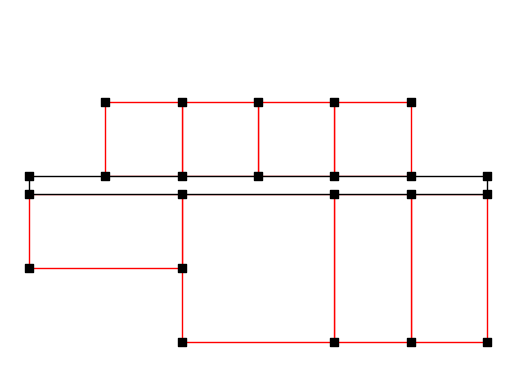

In [156]:
Rooms = [Corridor,Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]
Best = [[8, 7, 6, 5, 0, 4, 3, 2, 1], 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
print(Eval(Best))
conf(Best)

In [152]:
# 評価関数
def Eval(individual):
    seq, gap, dim = disassembly(individual)
    global Rooms
    Rooms,Pillarcorrdinate,Duplication,max_interval = quota(Rooms,individual)
    copy_Rooms=Rooms.copy()
    D = []# 距離
    F = []# 床
    W = []# 壁
    P = len(Pillarcorrdinate)# 柱の数
    copy_Rooms.pop(0)
    for room in copy_Rooms:
        D.append(sum([room.distance(i) for i in Rooms]))
        F.append(room.floor())
        W.append(room.wall())

    # construction_cost
    a,b,c=3000,109,14200
    dfl,dwl,wbs,dbs,hbm,hbs,wbm,h=0.12,0.1,0.6,0.3,0.8,0.92,0.6,3.1
    aw = 0.1*max_interval
    # 床
    C1 = 2*(a+100*b*dfl+c*dfl)+100*b*dbs+c*dbs
    # 壁
    C2 = a*(wbm-dwl+2*(hbm-dfl))+(100*b+c)*wbm*(hbm-dfl)+2*a*(h-hbm)+(100*b+c)*dwl*(h-hbm)+2*a*(hbs-dfl)+(100*b+c)*(wbs*(hbs-dfl))
    # 柱
    C3 = 4*a*aw*(h-dfl)+100*b*aw*aw*(h-dfl)+c*aw*aw*(h-dfl)
    Cc = C1*sum(F)+C2*(sum(W)-Duplication)+C3*P
    #　transportation_cost
    Tc = sum(D)

    return Cc,Tc

In [ ]:

lst = [(1,2),(2,4),(1,2)]
lst.append((2,4),(3,4))
len(set(lst))